In [1]:
from __future__ import division #for float divisors
from string import ascii_lowercase #for alphabet
import matplotlib.pyplot as plt #plotting

import re #regex utility
from collections import Counter #max values of dictionary

import numpy as np
from numpy import matrix #matrix operations
import pandas as pd
from collections import OrderedDict as odict

import pykov #markov chains
import itertools

### In this notebook, we will recreate Claude Shannon's Approximations from "A Mathmatical Theory of Communication"

 <img src="shan_img1.png",width=400,height=400>
---

In Claude Shannon's landmark 1948 paper *A Mathematical Theory of Communication*, he uses a series of approximations to generate strings of text. This is done by treating the language as a stochastic process where the presence of each letter is determined by the letter(s)$^*$ that proceed it.

These approximations utilize each letters frequency in text as well as their relative probabilities. 

#### Overview of Approximations

- **Zero-Order Approximation**

The probabilities of each letter occuring are equal meaning each letter is equally likely to appear in a word. This means that a sequence of letter is in effect randomly generated.


- **First-Order Approximation** 

The probability of each letter occuring is solely dependent on its relative frequency in the source text. This means that a sequence is generated in a way that reflects the letter's odds of appearing. 


- **Second-Order Approximation**

The probability of each letter occuring is dependent on the letter that direclty precedes it. A sequence is effectly generated using a Markov Chain


- **Third-Order Approximation**

The probability of each letter occuring is dependent on the 2 letters that precede it. A sequence can be generated using a Markov chain. 

**Our source text:** Chapter 1 of *Moby Dick*


<img src="moby_dick_img.jpg",width=200,height=200>

# Goals

___


### 1) Re-create Shannon's results using a series of approximations

### 2) Use additional statistical methods to see if we achieve better results*

**will be completed on a seperate jupyter notebook*

So let's get to it!

## 1) Recreating Shannon's Results

___ 

We will do this by using a series of approximations, in the following order

### [1.1 Zero-order approximation ](#section1.1)

### [1.2 First-order approximation](#section1.2)

### [1.3 Second-order approximation](#section1.3) 

### [1.4 Third-order approximation](#section1.4)

### [Results](#section1.5)

### [Future Directions](#section1.6)
---

 <a name="section1.1"></a> 
## 1.1 Zero-Order Approximation

___

In this approximation, Shannon writes:

**"The zero-order approximation is obtained by choosing all letters with the same probability and independently."**

That is, for a 27 character alphabet (26 letters + a space), each character will have an equal probability of $\frac{1}{27}$ of being chosen next in the sequence. 


In [2]:
#This probability in decimal form is...
1/27

0.037037037037037035

This means each character has a probability of 3.85% of being next in sequence

In [3]:
#Lets first define our alphabet
alphabet = ascii_lowercase + " " 
alphabet

'abcdefghijklmnopqrstuvwxyz '

As each of these values are equally likely to appear, we will not need a Markov Chain or any complex modeling technique - we can simply randomly create a sequence of characters

In [4]:
char = tuple(alphabet)
ZO_approx = ''.join(np.random.choice(char, size=10000, replace=True))
print ZO_approx[:100]

myy hhuqtkgfzmuya poceijjpobvqdzqhopkjbqapppdzcjvgnbavqhwxcmsprwkdh gmbuzoeqdgqshcbyzeqxrkdufixrvddl


Lets quickly analyze our results

In [5]:
def check_approx_for_words(approx):
    num_correct = 0
    list_of_corrct_words = []
    with open("dictionary.txt") as word_file: #English dictionary is used
        english_words = set(word.strip().lower() for word in word_file)
    approx_in_words = approx.split()
    for w in approx_in_words:
        if w in english_words:
            list_of_corrct_words.append(w)
            num_correct +=1
        
    print("In our approximation, we have producted " + str(num_correct) + " words")
    print("some words found: " + str(list_of_corrct_words[:5]))



In [6]:
check_approx_for_words(ZO_approx)

In our approximation, we have producted 5 words
some words found: ['ca', 'pip', 'sd', 'ax', 'geed']


 <a name="section1.2"></a> 
## 1.2 First-Order Approximation

___

**"The first-order approximation is obtained by choosing successive letters independently but
 each letter having the same probability that it has in the natural language"**

Now we will use the relative frequency of each letter ( the probability of it appearing in text)

In [7]:
mb_ch1 = "moby_dick_ch1.txt" #first chapter of moby dick

with open(mb_ch1) as f:
    text = f.read().strip()
    text = text.lower()       #convert to lowercase
    letter_freq_dict = {}
    for x in alphabet:
        letter_freq_dict[x] = text.count(x)

We now have our letters and their corresponding frequencies in a dictionary. Lets now use see how they distribute using a plot

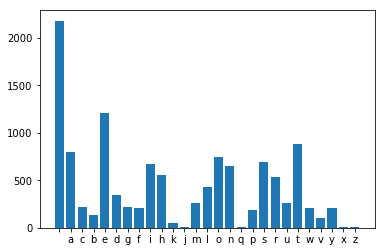

In [8]:
plt.bar(range(len(letter_freq_dict)), letter_freq_dict.values(), align='center')
plt.xticks(range(len(letter_freq_dict)), letter_freq_dict.keys())

plt.show()

This looks relatively consistent with the relative frequency of letters across text (though our plot includes the frequency of spaces in text)

<img src="rel_ltr_freq.png",width=300,height=300>

[source](https://en.wikipedia.org/wiki/Letter_frequency)

Now we can get each letter's relative frequency (probability) by just dividing their frequency by the total amount of letters in our sample text (first chapter of Moby Dick)

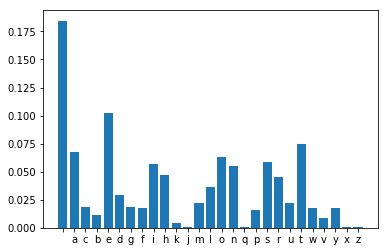

In [9]:
def freq_to_rel_freq(dct):
    dct_sum = 0
    for v in dct.values():
        dct_sum += v
    for key, value in dct.items():
        dct[key] = value / dct_sum
    return dct

freq_to_rel_freq(letter_freq_dict)

#lets see our values again to verify 
plt.bar(range(len(letter_freq_dict)), letter_freq_dict.values(), align='center')
plt.xticks(range(len(letter_freq_dict)), letter_freq_dict.keys())

plt.show()

Now let's see our first-order approximation!

In [10]:
FO_prob = tuple(letter_freq_dict.keys())
FO_approx =  ''.join(np.random.choice(FO_prob, size=10000, replace=True))
print(FO_approx[:100])

jgurhosawopnjgdccdpgslybwzosjizoerfdecnkwuydpsevvizdsengwkcdrmvelgpaaqylj hi rhmvihabmsaamzyuctpmolp


In [11]:
check_approx_for_words(FO_approx)

In our approximation, we have producted 4 words
some words found: ['hi', 'lr', 'tm', 'ox']


Our output is still far from a resembling English. Let's see how additional approximations change that

 <a name="section1.3"></a> 
## 1.3 Second-Order Approximation

___

### Quick Background

___


#### What is a Transition Matrix?

Say we have three states, **A**, **B**, and **C** 

**1)** Given that we are in a state **A**, we have three choices on where to go:

- We can stay in state **A**, which we are 30% likely to do
- We can go to state **B**, which we are 20% likely to do
- We can go to state **C**, which we are 50% likely to do

which we can represent with the row vector

$$
\begin{align}
T_1=\begin{bmatrix}
        .30 & .20 & .50
    \end{bmatrix}
\end{align}
$$

**2)** Continuing, if we move to state **B**,

- We can go to state **A**, which we are 10% likely to do
- We can stay in state **B**, which we are 60% likely to do
- We can go to state **C**, which we are 30% likely to do

which we can represent with the row vector

$$
\begin{align}
T_2=\begin{bmatrix}
        .10 & .60 & .30
    \end{bmatrix}
\end{align}
$$

**3)** Lastly, if we move to state **C**,

- We can go to state **A**, which we are 20% likely to do
- We can go to state **B**, which we are 40% likely to do
- We can stay in state  **C**, which we are 40% likely to do

which we can represent with the row vector

$$
\begin{align}
T_3=\begin{bmatrix}
        .20 & .40 & .40
    \end{bmatrix}
\end{align}
$$



#### Combining these three row vectors into a matrix, we can create the transition matrix **T**


$$
\begin{align}
    T=\begin{bmatrix}
         T_1\\
         T_2\\
         T_3
    \end{bmatrix}
        = \begin{bmatrix}
            .30 & .20 & .50\\
            .10 & .60 & .30\\
            .20 & .40 & .40
          \end{bmatrix}
\end{align}
$$

- **Where the *ith*, *jth* element of the matrix **T** gives us the probability that we will move from the *ith* state to the *jth* state**

We can see what this means more clearly in the matrix below, 

$$
\begin{align}
    T= \begin{bmatrix}
            .30 & .20 & .50\\
            .10 & .60 & .30\\
            .20 & .40 & .40
       \end{bmatrix}
       =\begin{bmatrix}
            T_{AA} & T_{AB} & T_{AC}\\
            T_{BA} & T_{BB} & T_{BC}\\
            T_{CA} & T_{CB} & T_{CC}
       \end{bmatrix}
\end{align}
$$


**Key Idea**:
Another way of thinking about this is to see each entry of the matrix as the probabilty of that two-state sequence occuring. This is consistent with the main limitation of transition matrices, which is that the probability of a state occuring relies *only* on the state that occured before it. It is also consistent 

**more on transition matrices [here](https://en.wikipedia.org/wiki/Stochastic_matrix)**

###  To use a Second-Order Approximation, we need the following transition matrix

---


$$
\begin{align}
    T_{SecondOrder}=\begin{bmatrix}
            T_{AA} & T_{AB} & T_{AC} & \dots & T_{AZ}\\
            T_{BA} & T_{BB} & T_{BC} &  \dots & T_{BZ}\\
            T_{CA} & T_{CB} & T_{CC} &  \dots & T_{CZ}\\
            \vdots & \vdots & \vdots &  \ddots & &\\
            T_{ZA} & T_{ZB} & T_{ZC}& & T_{ZZ} 
       \end{bmatrix}
\end{align}
$$



Note: I have ommitted the last column and row for clarity
### Now if we wish to create our transition matrix, we must first find the probability of each two-letter sequence occuring


#### So an example of the steps necessary can be illustrated by working out how we would find the probabilty of the two-letter sequence "AA"


** Step 1)** We must find $\textrm{freq}(AA)$, where

$$ \textrm{freq}(AA) = \textrm{frequency of a two-letter sequence containing "AA"} $$
 

**Step 2)** We must find the sum of frequencies of sequences that begin with A, which we can call $N$

$$ N_{A\eta} = \sum^{27}\textrm{freq}(A\eta) $$

**Step 3)** We can then find the probability of that two sequence, $P_{A\eta}$,

$$ P_{AA} = \frac{\textrm{freq}(AA)}{N_{A\eta}} = T_{AA} $$

### Step 0: Make reference matrix 

To make this exercise a little more illustrative, we will first create a sort of "reference matrix" in which the elements of the matrix are sequences we are interested in. This will come in handy later as we will use regular expressions to determine sequence frequencies. 

This matrix is essentially just our transition matrix with letter sequences instead of their corresponding probabilities.

For a second order approximation, the reference matrix **R** will look like this:


$$
\begin{align}
    R_{SecondOrder}=\begin{bmatrix}
            AA & AB & AC & \dots & AZ\\
            BA & BB & BC &  \dots & BZ\\
            CA & CB & CC &  \dots & CZ\\
            \vdots & \vdots & \vdots &  \ddots & &\\
            ZA & ZB & ZC& & ZZ 
       \end{bmatrix}
\end{align}
$$



To make this reference matrix (and subsequent reference matrices for higher-order approximations) I will use matrix addition. For example, our second-order approximation reference matrix will be built like the matrix addition equation below:

$$
\begin{align}
    R_{SecondOrder}=\begin{bmatrix}
            A & A & A & \dots & A\\
            B & B & B &  \dots & B\\
            C & C & C &  \dots & C\\
            \vdots & \vdots & \vdots &  \ddots & &\\
            Z & Z & Z& & Z 
       \end{bmatrix}+\begin{bmatrix}
            A & B & C & \dots & Z\\
            A & B & C &  \dots & Z\\
            A & B & C &  \dots & Z\\
            \vdots & \vdots & \vdots &  \ddots & &\\
            A & B & C& & Z 
       \end{bmatrix}=\begin{bmatrix}
            AA & AB & AC & \dots & AZ\\
            BA & BB & BC &  \dots & BZ\\
            CA & CB & CC &  \dots & CZ\\
            \vdots & \vdots & \vdots &  \ddots & &\\
            ZA & ZB & ZC& & ZZ 
       \end{bmatrix}
\end{align}
$$




**note**: in actuality, our matrix would have one extra row and column for the " " character for clarity I have chosen to omit this detail

In [12]:
#CREATES AN N X N MATRIX WHERE N IS THE LENGTH OF THE "ALPHABET" USED
#AND EACH ROW IS THE NTH ELEMENT OF THE "ALPHABET" REPEATED N TIMES
#AKA THE TRANSPOSE OF THE ABOVE MATRIX

#CONVERT OUR 27 CHARACTER ALPHABET TO A LIST 
alpha_vec = list(alphabet)


def make_char_matrix(character_list):
    oneD_matrix = [] #initializes a list
    alpha_length = len(character_list) #determines how many of each letter to append to the list
    for ltr in character_list: #list comprehension shortening
        for i in range(alpha_length):
            oneD_matrix.append(ltr)
    global alpha_matrix_one
    alpha_matrix_one = np.array(oneD_matrix).reshape(alpha_length,alpha_length) #convert to numpy array
    
    
make_char_matrix(alpha_vec)

In [13]:
#CREATES AN N X N MATRIX WHERE N IS THE LENGTH OF THE 'ALPHABET' USED
#AND EACH ROW CONTAINS THE ELEMENTS OF THE USED "ALPHABET"

def make_alphabet_matrix(character_list):
    oneD_matrix = []
    alpha_length = len(character_list)
    for i in range(len(character_list)):
        oneD_matrix.append(character_list)
    global alpha_matrix_two 
    alpha_matrix_two = np.array(oneD_matrix).reshape(alpha_length,alpha_length)
                   
make_alphabet_matrix(alpha_vec)

In [14]:
print(alpha_matrix_one.shape) 
print(alpha_matrix_two.shape)

#ref_matrix = np.dot(alpha_matrix_one,alpha_matrix_two)
#ref_matrix = np.vdot(alpha_matrix_one, alpha_vec)

(27, 27)
(27, 27)


In [15]:
#CONVERT TO PANDAS DATAFRAMES
alpha_df1 = pd.DataFrame(alpha_matrix_one, columns=alpha_vec)
alpha_df2 = pd.DataFrame(alpha_matrix_two, columns=alpha_vec) #though the column names do not make sense now,

print "alpha df1: "
print alpha_df1.head()                                        #having identical headers makes life easier
print "alpha df2: "
print alpha_df2.head()

alpha df1: 
   a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
0  a  a  a  a  a  a  a  a  a  a ...  a  a  a  a  a  a  a  a  a  a
1  b  b  b  b  b  b  b  b  b  b ...  b  b  b  b  b  b  b  b  b  b
2  c  c  c  c  c  c  c  c  c  c ...  c  c  c  c  c  c  c  c  c  c
3  d  d  d  d  d  d  d  d  d  d ...  d  d  d  d  d  d  d  d  d  d
4  e  e  e  e  e  e  e  e  e  e ...  e  e  e  e  e  e  e  e  e  e

[5 rows x 27 columns]
alpha df2: 
   a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
0  a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
1  a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
2  a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
3  a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   
4  a  b  c  d  e  f  g  h  i  j ...  r  s  t  u  v  w  x  y  z   

[5 rows x 27 columns]


In [16]:
def matrix_addition(dataframe1,dataframe2):
    global alpha_df3
    alpha_df3 = pd.DataFrame()#initialize dataframe
    for ltr in alphabet:
        alpha_df3[ltr] = dataframe1[ltr].str.cat(dataframe2[ltr])

matrix_addition(alpha_df1, alpha_df2)

In [17]:
alpha_df3 = alpha_df3.set_index(alpha_df3.ix[:,-1])    #reindex dataframe to revert back to orignal index

print alpha_df3.head()
print alpha_df3.shape

     a   b   c   d   e   f   g   h   i   j ...   r   s   t   u   v   w   x  \
                                           ...                               
a   aa  ab  ac  ad  ae  af  ag  ah  ai  aj ...  ar  as  at  au  av  aw  ax   
b   ba  bb  bc  bd  be  bf  bg  bh  bi  bj ...  br  bs  bt  bu  bv  bw  bx   
c   ca  cb  cc  cd  ce  cf  cg  ch  ci  cj ...  cr  cs  ct  cu  cv  cw  cx   
d   da  db  dc  dd  de  df  dg  dh  di  dj ...  dr  ds  dt  du  dv  dw  dx   
e   ea  eb  ec  ed  ee  ef  eg  eh  ei  ej ...  er  es  et  eu  ev  ew  ex   

     y   z      
                
a   ay  az  a   
b   by  bz  b   
c   cy  cz  c   
d   dy  dz  d   
e   ey  ez  e   

[5 rows x 27 columns]
(27, 27)


 Now we have the transition matrix shown above!

### Step 1: Find the frequency of each two-letter sequence (bigram)

For this part, we will be using regular expression searches to find the count of each bigram

In [18]:
SO_freq_dct = {}
regex_template = r'in'

def freq_of_seq(output_dict,dataframe): 
    df_dim = len(dataframe.columns)
    jth = 0
    with open(mb_ch1) as f:                  #opens our text source as a string 
        text = f.read().strip()
        text = text.lower()
    for i in range(df_dim):
        j = 0
        jth += 1
        while len(output_dict) < jth*df_dim: #for row by row iteration
            entry = dataframe.iloc[i,j]
            regex = regex_template.replace('in',str(entry))
            count = len(re.findall("(?=%s)" % regex, text))
            output_dict[entry] = count
            j += 1
        
    return output_dict       

In [19]:
freq_of_seq(SO_freq_dct, alpha_df3)

print "length of dictionary: " + str(len(SO_freq_dct.values())) #We expect the length to be 729 (27*27)

print "five most common bigrams: " + str(dict(Counter(SO_freq_dct).most_common(5)))


length of dictionary: 729
five most common bigrams: {' a': 260, 'th': 308, 'e ': 350, ' t': 350, 'he': 243}


In [20]:
SO_TM = alpha_df3.replace(SO_freq_dct)
SO_TM.head()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,
,,,,,,,,,,,,,,,,,,,,,
a,0,23,17,16,3,3,26,1,26,1,...,70,70,102,5,18,5,1,23,4,79
b,11,2,0,0,39,0,0,0,6,0,...,13,2,1,23,0,0,0,9,0,2
c,41,0,3,0,32,0,0,36,16,0,...,7,1,16,8,0,0,0,1,0,4
d,3,0,0,3,47,1,3,0,24,0,...,7,18,0,2,0,0,0,3,0,168
e,75,0,23,56,47,9,7,4,16,0,...,173,113,37,0,34,5,7,22,1,350


### Step 2: Find the sum of each row

a     794
b     132
c     215
d     341
e    1209
f     208
g     213
h     550
i     672
j      11
k      55
l     424
m     264
n     647
o     747
p     187
q       9
r     536
s     680
t     875
u     264
v     104
w     199
x      11
y     210
z       7
     1898
dtype: int64


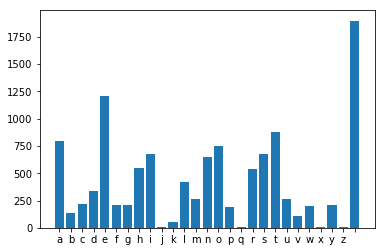

In [21]:
print SO_TM.sum(0)   #built-in pandas column sum function

SO_row_sums = list(SO_TM.sum(0))    #1 for column sum (0 for row sums)

SO_row_sum_dct = odict(zip(alpha_vec, SO_row_sums)) #save these values to an order-preserving dictionary

plt.bar(range(len(SO_row_sum_dct)), SO_row_sum_dct.values(), align='center')
plt.xticks(range(len(SO_row_sum_dct)), SO_row_sum_dct.keys())

plt.show()

We can see that in our source text, the bigram with the highest frequency is the one that begins with a space which is to be expected as each word begins with this character.

### Step 3: Determine Probability of Each Digram (Relative Frequency)


In this step, we are simply normalizing the values of each row to sum to one

In [22]:
SO_norm_dct = {}

def norm_dct(freq_dct,row_sum_dct,output_dct):
    dct_dim = len(row_sum_dct) #27 in this case, 
    j = 0 
    for i in range(1, len(row_sum_dct)+1): 
        while len(output_dct) < i*dct_dim:
            row_ltr = alpha_vec[j]
            row_sum = row_sum_dct[row_ltr]
            for second_ltr in alphabet:
                bigram = row_ltr+second_ltr
                freq = freq_dct[bigram]
                norm_freq = freq / row_sum          #normalize by row sum as it the elements of a row are 
                output_dct[bigram] = norm_freq      #the possible transitions 
        j +=1 
        
    return output_dct

In [23]:
norm_dct(SO_freq_dct,SO_row_sum_dct,SO_norm_dct)

print "length of dictionary: " + str(len(SO_norm_dct))

length of dictionary: 729


### So just to recap, we have done the following
 
- a) Found the frequency of each bigram
- b) Found the sum of each set of bigrams that share the same "starting point"
- c) Normalized the frequency each of each bigram such that the probablities of each set sum to 1


### Now we will be using [Pykov](https://github.com/riccardoscalco/Pykov) to work with our second-order Markov Chain

First, we must slighly alter our normalized second-order dictionary so that each bigram is represented by a tuple.

In [24]:
for bigram in SO_norm_dct:
    SO_norm_dct[tuple(bigram)] = SO_norm_dct.pop(bigram)

Now lets turn this dictionary into a Pykov matrix so that we can finally get our second-order approximation results

In [25]:
T = pykov.Chain(SO_norm_dct)

In [26]:
SO_walk = T.walk(10000)
SO_approx = ''.join(SO_walk)
print(SO_approx[:100])

thero t wndsehayilarelloigone thowh istrantonthis an tware pend s t s pucaminde drom f iscofon s she


In [27]:
check_approx_for_words(SO_approx)

In our approximation, we have producted 304 words
some words found: ['an', 'pend', 'ant', 'ad', 'hen']


For a second-order approximation, we produced 304 words!

 <a name="section1.4"></a> 
## 1.4 Third Order Approximation

---

For a third-order approximation, we will now be focusing on the trigrams present in our source text.

**Steps**

- Get a count of each trigram
- calculate probability of each trigram, in other words 
$$ p_{ijk} = \frac{N_{ijk}}{N_{ij*}} $$
- assemble markov model with $n^2$ states


In [28]:
#STEP 1 Get a count of each trigram

#lets create a trigram count dictionary

TO_freq_dict = {}
for first_ltr in alpha_vec:
    for sec_ltr in alpha_vec:
        for thrd_ltr in alpha_vec:
            trigram = first_ltr + sec_ltr + thrd_ltr
            TO_freq_dict[trigram] = 0
            
len(TO_freq_dict)  #27*27*27 = 19683

19683

In [29]:
#Now lets use a moving window approach to count each trigram

with open(mb_ch1) as f:
    text = f.read().strip()
    text = text.lower()       #convert to lowercase
    for i in range(len(text)-2):
        j = 3 + i              # "i" indexes the start of the trigram and "j" indexes the end - "moving window"
        trigram = text[i:j]
        if trigram in TO_freq_dict.keys():
            TO_freq_dict[trigram] += 1

print(len(TO_freq_dict))


19683


In [30]:
print "five most common trigrams: " + str(dict(Counter(TO_freq_dict).most_common(5)))

five most common trigrams: {'and': 104, 'nd ': 94, 'the': 187, 'he ': 134, ' th': 250}


In [31]:
def norm_trigam(input_dct,output_norm_dct): 
    init_bigram_freq_dict = {} #contains freq of (ltr)(ltr)(*) trigrams
    
    for n_trigram in input_dct.keys(): #find frequency of each initial bigram
        strt_bigram = n_trigram[:2]
        if strt_bigram in init_bigram_freq_dict:
            init_bigram_freq_dict[strt_bigram] += input_dct[n_trigram]
        else:
            init_bigram_freq_dict[strt_bigram] = input_dct[n_trigram]
            
    for n_trigram in input_dct.keys(): #normalize trigram using count of initial bigram
        strt_bigram = n_trigram[:2]
        freq = input_dct[n_trigram]
        norm_f = init_bigram_freq_dict[strt_bigram]
        if norm_f > 0:
            output_norm_dct[n_trigram] = freq / norm_f
        
    return output_norm_dct
    

In [32]:
TO_norm_dict = {}
norm_trigam(TO_freq_dict, TO_norm_dict)
print("done")

done


In [33]:
TO_norm_dict

{'xtw': 0.0,
 'xtv': 0.0,
 'xtu': 0.0,
 'xtt': 0.0,
 'xts': 0.0,
 'xtr': 0.6666666666666666,
 'xtq': 0.0,
 'xtp': 0.0,
 'xtz': 0.0,
 'xty': 0.0,
 'xtx': 0.0,
 'xtg': 0.0,
 'xtf': 0.0,
 'xte': 0.3333333333333333,
 'xtd': 0.0,
 'xtc': 0.0,
 'xtb': 0.0,
 'xta': 0.0,
 'xto': 0.0,
 'xtn': 0.0,
 'xtm': 0.0,
 'xtl': 0.0,
 'xtk': 0.0,
 'xtj': 0.0,
 'xti': 0.0,
 'xth': 0.0,
 'evl': 0.0,
 'xt ': 0.0,
 'rlm': 0.0,
 'rll': 0.0,
 'rlo': 0.0,
 ' y ': 0.0,
 'rle': 0.1,
 'rld': 0.4,
 'rlg': 0.0,
 'lms': 0.0,
 'rla': 0.2,
 'rlc': 0.0,
 'rlb': 0.0,
 ' yh': 0.0,
 ' yi': 0.0,
 ' yj': 0.0,
 ' yk': 0.0,
 ' yl': 0.0,
 ' ym': 0.0,
 ' yn': 0.0,
 ' yo': 0.8648648648648649,
 ' ya': 0.0,
 ' yb': 0.0,
 ' yc': 0.0,
 ' yd': 0.0,
 ' ye': 0.13513513513513514,
 ' yf': 0.0,
 ' yg': 0.0,
 ' yx': 0.0,
 ' yy': 0.0,
 ' yz': 0.0,
 ' yp': 0.0,
 'lml': 0.0,
 ' yr': 0.0,
 ' ys': 0.0,
 ' yt': 0.0,
 ' yu': 0.0,
 ' yv': 0.0,
 'rlx': 0.0,
 'ajc': 0.0,
 'voe': 0.0,
 'rlz': 0.0,
 'up ': 0.26666666666666666,
 'lma': 0.3333333333333333

Now to turn this into a format we can use in Pykov

In [34]:
for t_trigram in TO_norm_dict.keys():
    transition = [t_trigram[:2],t_trigram[-2:]]
    TO_norm_dict[tuple(transition)] = TO_norm_dict.pop(t_trigram)

In [35]:
TO_norm_dict

{('vi', 'ic'): 0.0,
 ('eo', 'oh'): 0.0,
 ('wo', 'ol'): 0.0,
 ('ec', 'cy'): 0.0,
 ('in', 'ne'): 0.01092896174863388,
 ('x ', ' f'): 0.0,
 ('up', 'pn'): 0.0,
 ('my', 'y '): 0.75,
 ('ef', 'ft'): 0.1111111111111111,
 ('k ', ' p'): 0.0,
 ('nu', 'uj'): 0.0,
 ('ks', 'sa'): 0.0,
 ('ca', 'a '): 0.024390243902439025,
 ('og', 'gg'): 0.0,
 ('hi', 'in'): 0.2631578947368421,
 ('uy', 'yo'): 0.0,
 ('jo', 'og'): 0.0,
 ('mo', 'oq'): 0.0,
 ('dd', 'dp'): 0.0,
 ('ch', 'hl'): 0.0,
 ('eq', 'ql'): 0.0,
 ('wl', 'lo'): 0.0,
 ('oi', 'iu'): 0.0,
 ('rk', 'kc'): 0.0,
 ('ed', 'db'): 0.0,
 ('ey', 'yp'): 0.0,
 ('na', 'at'): 0.2,
 ('wh', 'hp'): 0.0,
 ('eo', 'op'): 1.0,
 ('e ', ' k'): 0.008571428571428572,
 ('ti', 'ip'): 0.0,
 ('fu', 'ua'): 0.0,
 ('si', 'io'): 0.0625,
 ('hy', 'ye'): 0.0,
 ('lu', 'uz'): 0.0,
 ('ne', 'eb'): 0.0,
 ('bl', 'lx'): 0.0,
 ('ht', 'tx'): 0.0,
 ('ny', 'yj'): 0.0,
 ('xt', 'ta'): 0.0,
 ('eg', 'gc'): 0.0,
 ('if', 'fi'): 0.15384615384615385,
 ('gu', 'ua'): 0.0,
 ('cy', 'yi'): 0.0,
 ('va', 'an'): 0.333

In [36]:
TO_T = pykov.Chain(TO_norm_dict)

TO_walk = TO_T.walk(1000)
TO_approx = ''.join(TO_walk)

#print TO_approx
#We need to remove the duplicate characters in our approximation - we can do that by only printing odd-number indices
tran_TO_approx = []
for i in range(0, len(TO_approx),2):
    odd_char = TO_approx[i]
    tran_TO_approx.append(odd_char)
    
tran_TO_approx = ''.join(tran_TO_approx)
    
print tran_TO_approx[:100]

on way not ing fors withemehou yet the what rues you par the rave est the ing ovest yould fartursee 


In [37]:
check_approx_for_words(tran_TO_approx)

In our approximation, we have producted 72 words
some words found: ['on', 'way', 'not', 'yet', 'the']


Using a Third-Order Approximation, we produced 72 words! 

 <a name="section1.5"></a> 
 
## Results

Lets compare our results

In [38]:
print("Our Zero-Order approximation:")
print("\n")
print(SO_approx[:200])
print(" \n\n")

print("Our First-Order approximation:")
print("\n")
print(FO_approx[:200])
print(" \n\n")

print("Our Second-Order approximation:")
print("\n")
print(SO_approx[:200])
print(" \n\n")

print("Our Third-Order approximation:")
print("\n")
print(tran_TO_approx[:200])


Our Zero-Order approximation:


thero t wndsehayilarelloigone thowh istrantonthis an tware pend s t s pucaminde drom f iscofon s sheshaneay te y ant ad twhe t theve atovemamengllunds gh i thed wnomye tsig hen hatorttrshoyong ct bron
 


Our First-Order approximation:


jgurhosawopnjgdccdpgslybwzosjizoerfdecnkwuydpsevvizdsengwkcdrmvelgpaaqylj hi rhmvihabmsaamzyuctpmolphrfzui acxtribpjlajrvknkqidgacabperdvmdijyyzfqttrgd  rghbtbpqduqpufd zcrs gugtlppeyfiqmgtzjydvfiutxw
 


Our Second-Order approximation:


thero t wndsehayilarelloigone thowh istrantonthis an tware pend s t s pucaminde drom f iscofon s sheshaneay te y ant ad twhe t theve atovemamengllunds gh i thed wnomye tsig hen hatorttrshoyong ct bron
 


Our Third-Order approximation:


on way not ing fors withemehou yet the what rues you par the rave est the ing ovest yould fartursee but anights gethouceithe i st broicanglooreame pas and any beithe clich ory plusether i watigh an up


 <a name="section1.6"></a> 
## Future Directions

- **Higher-Order Approximations**

We can try higher-order approximations (such as a Fourth-Order approximation where the next letter depends on the previous 3) but according to Chen and Goodman (1998), we will not see significant improvements using higher-order approxiations until our source data becomes very large (1e6 sentences). 

Higher-Order approximations also become exponentially more costly and the data much more sparse

- **Word-length**

We can also introduce word length as a factor. This can be done by artificially truncating produced words. For example in Miller et. al (1958), there exists a phenomenon where a) the frequency of a word in a source text **F** and b) its spot in a list of descending word frequency **R** are related by a shared constant **F** by the following relation 
$$FR_{f} = K$$

In the paper, they discuss that this constant *K* also corresponds to the word's rank in increasing length

$$K_{approx} =  R_{l}$$
- where $R_{l}$ is the rank of the word in order of increasing length

*So we can form a relationship between word length and its predicted frequency that can be futher exploited*

[paper](http://ac.els-cdn.com/S0019995858902298/1-s2.0-S0019995858902298-main.pdf?_tid=6d73f248-5c62-11e7-9607-00000aacb35e&acdnat=1498696527_fae5e2fb39cad964124f038a173de919)